In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Input
from keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix
from mtcnn import MTCNN
import cv2

# Path to dataset directory containing real and fake images
train_data_dir = '/content/drive/MyDrive/Images/dataset/train'
test_data_dir = '/content/drive/MyDrive/Images/dataset/test'

# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Batch size
batch_size = 32

# Preprocessing and data augmentation for training
train_datagen_with_mtcnn = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Preprocessing for testing/validation
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generator for training data with MTCNN preprocessing
train_generator_with_mtcnn = train_datagen_with_mtcnn.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Load InceptionResNetV2 pre-trained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

# InceptionResNetV2 model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# MTCNN for face detection
detector = MTCNN()

# Define combined model
input_tensor = Input(shape=(img_width, img_height, 3))
processed_image = base_model(input_tensor)
output = GlobalAveragePooling2D()(processed_image)
output = Dense(1, activation='sigmoid')(output)
combined_model = Model(inputs=input_tensor, outputs=output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the combined model
history_combined = combined_model.fit(
    train_generator_with_mtcnn,
    steps_per_epoch=train_generator_with_mtcnn.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)

# Evaluate the combined model
test_generator.reset()
y_pred = combined_model.predict(test_generator, steps=test_generator.samples // batch_size)
y_pred = np.round(y_pred)
y_true = test_generator.classes

# Take only the first 100 values for evaluation
y_pred = y_pred[:100]
y_true = y_true[:100]

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy with InceptionResNet V2:", accuracy*100)


Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
219055592/219055592 [==============================] - 10s 0us/step
Epoch 1/10
6/6 [==============================] - 308s 42s/step - loss: 0.7085 - accuracy: 0.7262 - val_loss: 0.7634 - val_accuracy: 0.8646
Epoch 2/10
6/6 [==============================] - 5s 960ms/step - loss: 0.3906 - accuracy: 0.8750 - val_loss: 7.4044 - val_accuracy: 0.4323
Epoch 3/10
6/6 [==============================] - 5s 782ms/step - loss: 0.3251 - accuracy: 0.8571 - val_loss: 28.3324 - val_accuracy: 0.5052
Epoch 4/10
6/6 [==============================] - 6s 1s/step - loss: 0.1578 - accuracy: 0.9286 - val_loss: 22.6632 - val_accuracy: 0.5052
Epoch 5/10
6/6 [==============================] - 5s 798ms/step - loss: 0.1284 - accuracy: 0.9405 - val_loss: 2.6234 - val_accuracy: 0.5677
Epoch 6/10
6/6 [==============================] - 6s 1s/step - loss: 0.2575 - accuracy: 0.9167 - val_loss: 34.5388 - val_accuracy: 0.5000
Epoch 7/10
6/

In [5]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy with InceptionResNet V1 and MTCNN:", accuracy*100)

Accuracy with InceptionResNet V1 and MTCNN: 83.0


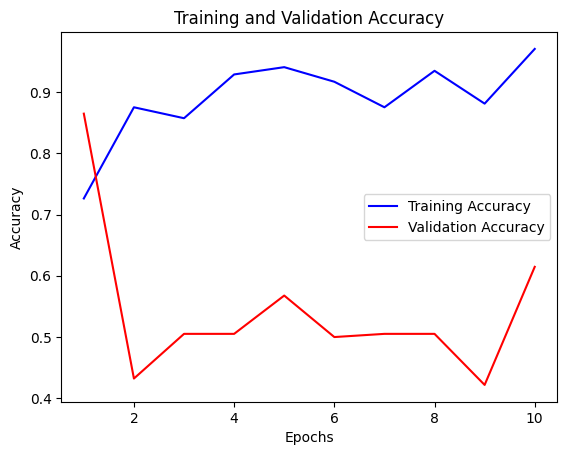

In [6]:
import matplotlib.pyplot as plt

# Extract accuracy values from the training history
train_accuracy = history_combined.history['accuracy']
val_accuracy = history_combined.history['val_accuracy']

# Create a line plot
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.1 MB/

In [30]:
import cv2
from keras.preprocessing import image
import numpy as np

# Function to preprocess image with MTCNN
def preprocess_image_mtcnn_for_prediction(image):
    result = detector.detect_faces(image)
    if result:
        x, y, w, h = result[0]['box']
        cropped_img = image[y:y+h, x:x+w]
        resized_img = cv2.resize(cropped_img, (img_width, img_height))
        return resized_img
    else:
        return None

# Define prediction function
def predict_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Preprocess image with MTCNN
    img = preprocess_image_mtcnn_for_prediction(img)

    if img is not None:
        # Expand dimensions and normalize image
        img = np.expand_dims(img, axis=0)
        img = img / 255.0

        # Make prediction
        prediction = combined_model.predict(img)[0]
        if prediction >= 0.5:
            label = "Real"
        else:
            label = "Fake"
        return label
    else:
        return "No face detected"

# Pass image path to the predict_image function
image_path = "/content/fake_frame_9.png"
output_label = predict_image(image_path)
print("Output Label:", output_label)


1/1 [==============================] - 0s 38ms/step
Output Label: Fake


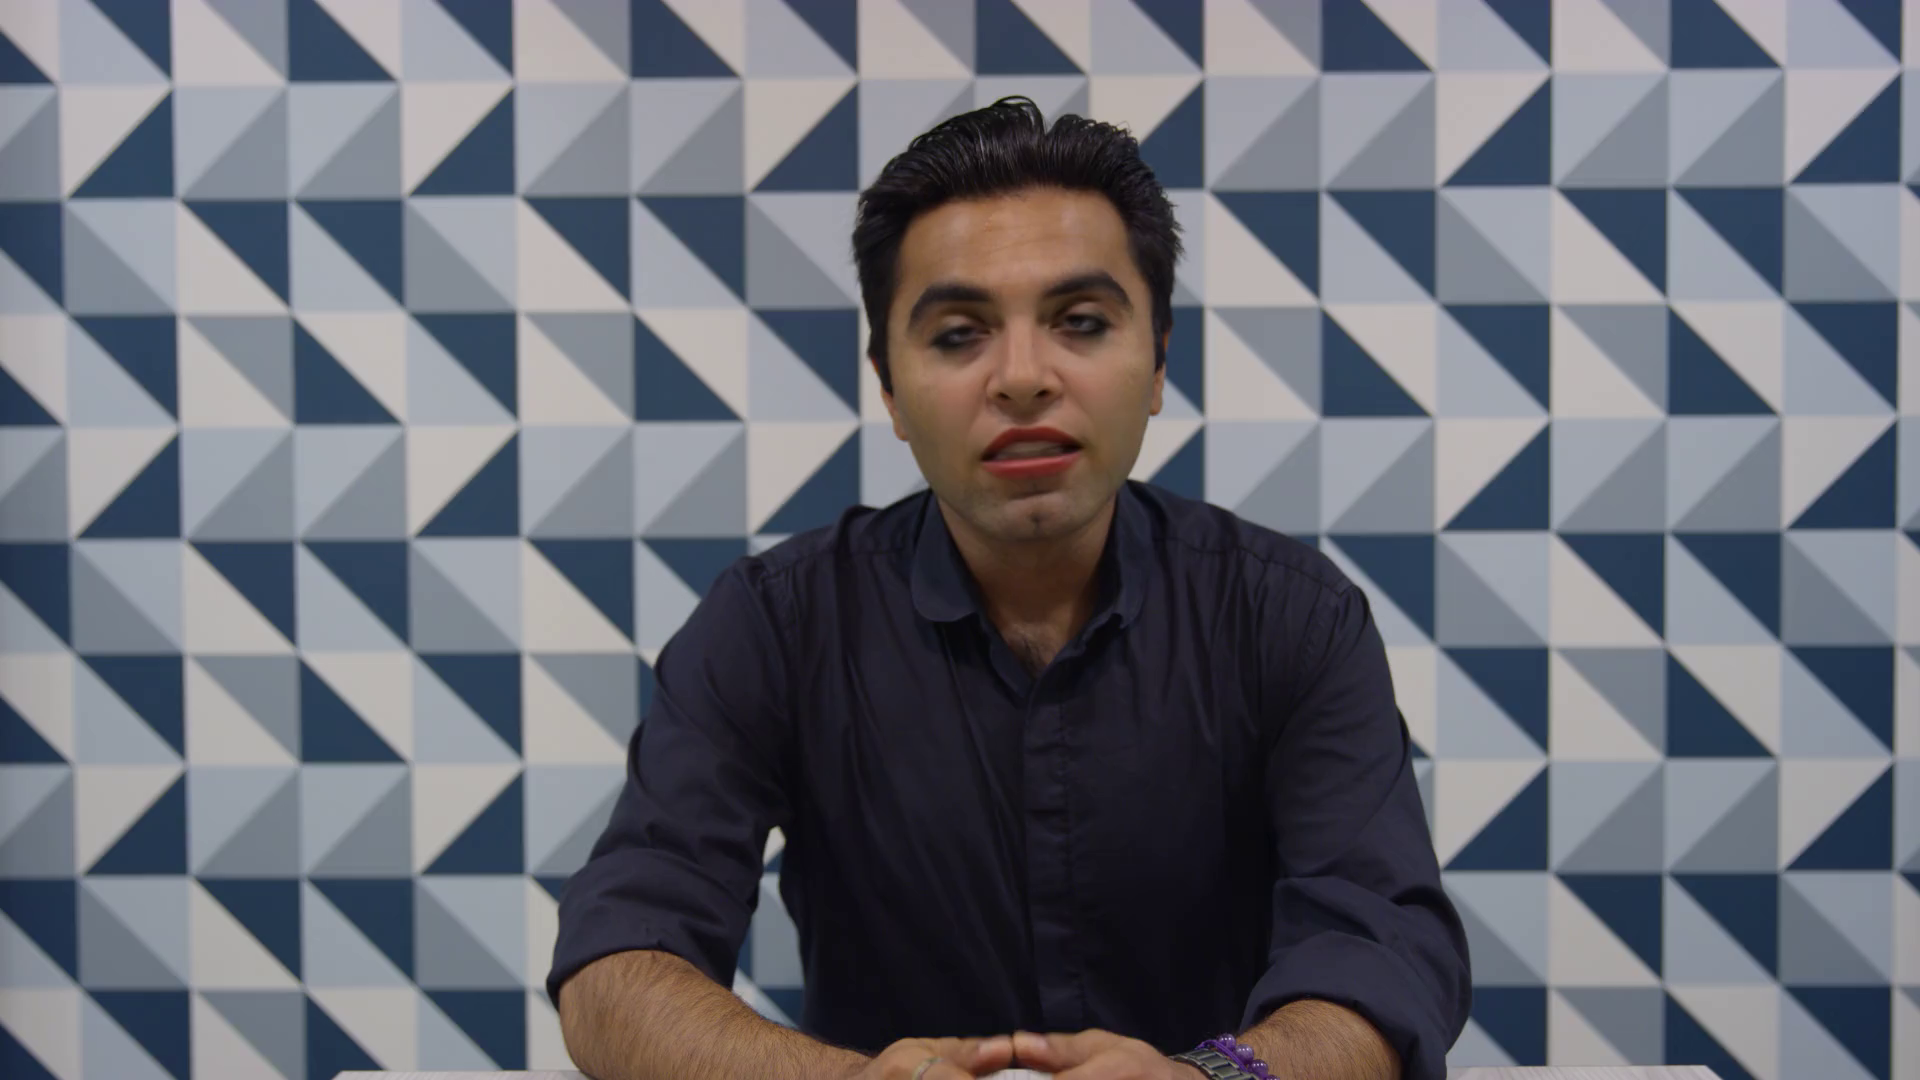

---------- Fake ----------


In [31]:
import cv2
from google.colab.patches import cv2_imshow
# Open the image.
img = cv2.imread(image_path)
cv2_imshow(img)
print("----------",output_label,"----------")